# Conditional likelihoods of trajectories

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from scipy import stats, interpolate
from numba import guvectorize,float64

import os
import glob

In [2]:
matplotlib.rc_file_defaults()

In [3]:
from analyzer import analyzer

In [51]:
run = 10
paths = glob.glob(os.path.expandvars('$HOME/run{}/*'.format(run)))
mutual_informations = np.concatenate([np.load(p) for p in paths])
num_r, _, length = mutual_informations.shape
mutual_informations.shape

(100, 2, 49999)

In [119]:
offset = 300

x = np.linspace(np.max(mutual_informations[:,0,0])+offset,np.min(mutual_informations[:,0,-1]),50000)
timespan = x.max() - x.min()
mi = np.zeros((num_r, len(x)))
for i, old in enumerate(mutual_informations):
    mi[i] = np.interp(x, old[0], old[1])
x=x-offset
mi_mean = np.mean(mi, axis=0)

In [120]:
def subset_indices(num_responses, subset_signals, subset_responses):
    assert subset_responses <= num_responses
    indices = np.zeros((subset_signals * subset_responses, 2), dtype=int)
    for s in range(subset_signals):
        for r in range(subset_responses):
            indices[s*subset_responses + r] = [s, r]
    return indices.T
    

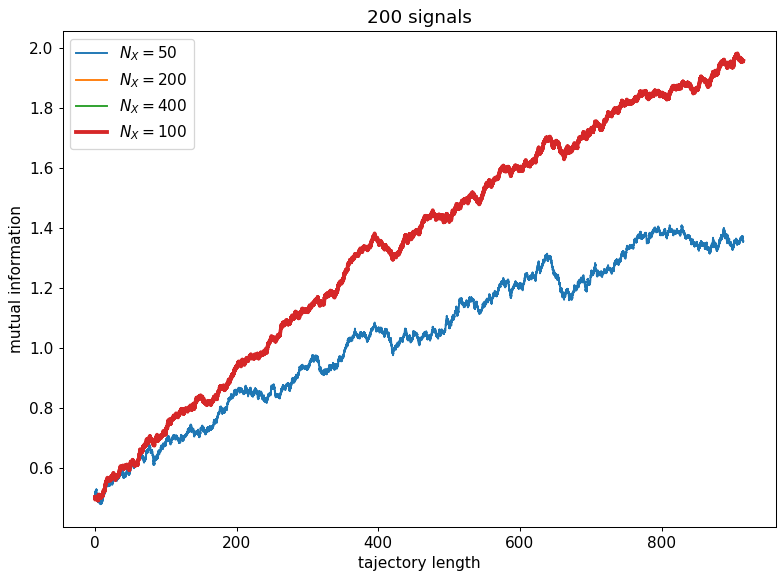

In [121]:
for r in [50, 200, 400]:
    subset_mean = np.mean(mi[:r], axis=0)
    plt.plot(x, subset_mean, label='$N_X={}$'.format(r))
plt.plot(x, mi_mean, label='$N_X={}$'.format(num_r), linewidth=3)
plt.legend()
plt.title('200 signals')
plt.ylabel('mutual information')
plt.xlabel('tajectory length');

In [122]:
numerical_x = np.array([6.10351562e-01, 1.22070312e+00, 2.44140625e+00, 4.88281250e+00,
       9.76562500e+00, 1.95312500e+01, 3.90625000e+01, 7.81250000e+01,
       1.56250000e+02, 3.12500000e+02, 6.25000000e+02, 1.25000000e+03,
       2.50000000e+03])
numerical = np.array([0.07155042, 0.07221034, 0.07352942, 0.07616464, 0.08142376,
       0.09190024, 0.1127109 , 0.15391634, 0.23541893, 0.39725253,
       0.72029812, 1.36630923, 2.65833046])

In [123]:
def mut_inf(lamda, rho):
    return lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
from scipy.optimize import curve_fit
def linear(t, inf_rate, offset):
    return t * inf_rate + offset

def rate_from_curve(x, y):
    (rate, offset), _ = curve_fit(linear, x, y, sigma=np.exp(-x/np.max(x)))
    return rate, offset


theoretical_rate = mut_inf(0.005, 0.005)
rate, offset = rate_from_curve(x, mi_mean)
rate_numerical, _ = rate_from_curve(numerical_x, numerical)
print("analytical:  {}\nnumerical:   {}\nmonte carlo: {}".format(theoretical_rate, rate_numerical, rate))

analytical:  0.0010355339059327378
numerical:   0.0010345131030511097
monte carlo: 0.0014846639597421109


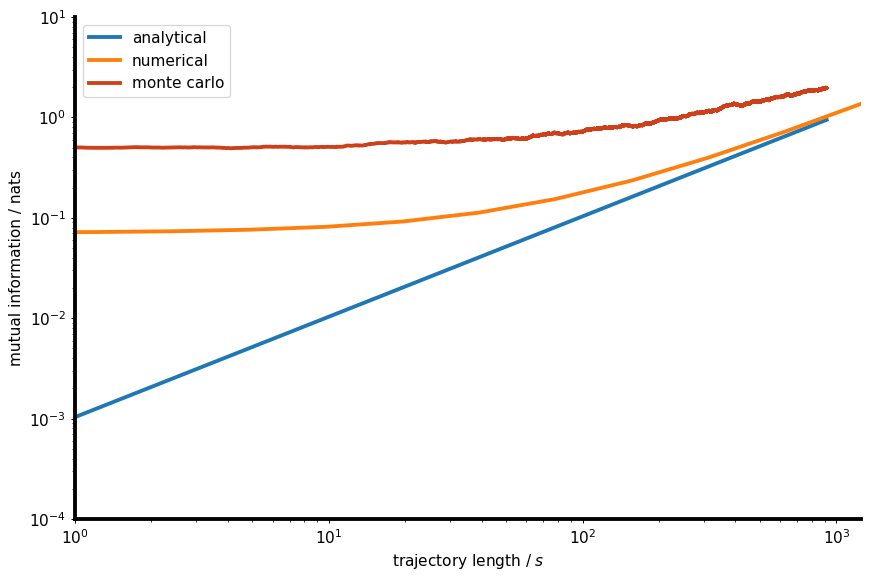

In [124]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})
plt.plot(x, theoretical_rate*x, label='analytical', linewidth=3)
plt.plot(numerical_x, numerical, linewidth=3, label='numerical')

plt.plot(x, mi_mean, label='monte carlo', linewidth=3, color='#CD401A')

plt.xlim(1,1250)

ax = plt.gca()
for pos in ['right', 'top']:
    ax.spines[pos].set_visible(False)
    
for pos in ['left', 'bottom']:
    ax.spines[pos].set_linewidth(3)

plt.ylabel('mutual information / nats')
plt.xlabel('trajectory length $/\\; s$')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4,1e1)

plt.gcf().set_size_inches(28/2.54, 18/2.54)
plt.savefig('poster_plot_3.pdf')

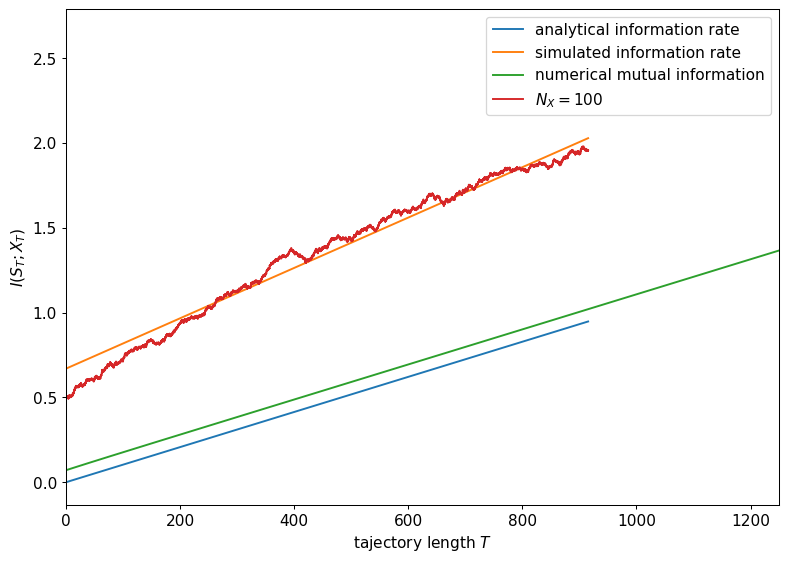

In [125]:
plt.plot(x, theoretical_rate*x, label='analytical information rate')
plt.plot(x, linear(x, rate, offset), label='simulated information rate')
plt.plot(numerical_x, numerical, label='numerical mutual information')
plt.plot(x, mi_mean, label='$N_X={}$'.format(num_r))
plt.ylabel('$I(S_T;X_T)$')
plt.xlabel('tajectory length $T$')
plt.xlim(0,1250)
plt.legend();

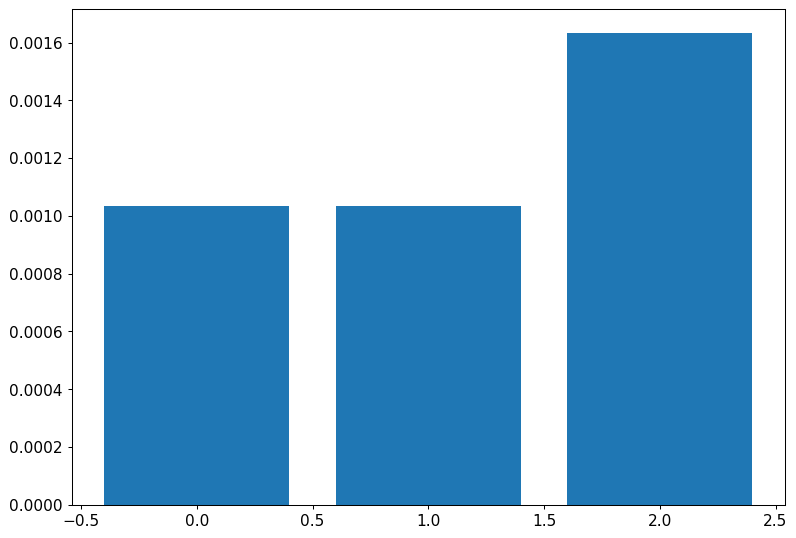

In [63]:
plt.bar(x=np.arange(3), height=[theoretical_rate, rate_from_curve(numerical_x, numerical)[0], rate_from_curve(x, mi_mean)[0]]);

In [22]:
def mov_avrg(x, y, n=3):
    return x[n:], (y[n:] - y[:-n]) / (x[n:] - x[:-n])

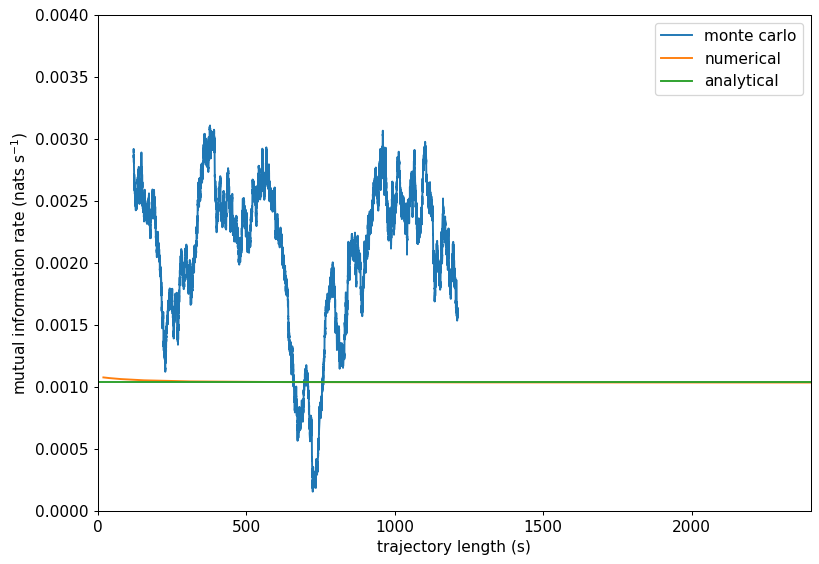

In [25]:
new_x, new_y = mov_avrg(x, mi_mean, 5000)
plt.plot(new_x, new_y, label='monte carlo')
new_x, new_y = mov_avrg(numerical_x, numerical, 5)
plt.plot(new_x, new_y, label='numerical')
plt.plot([0,2500], [theoretical_rate, theoretical_rate], label='analytical')
plt.ylim(0, 0.004)
plt.xlim(0, 2400)
plt.ylabel('mutual information rate (nats $\mathrm{s}^{-1}$)')
plt.xlabel('trajectory length (s)')
plt.legend();

In [47]:
import mutual_information
import importlib
importlib.reload(mutual_information);

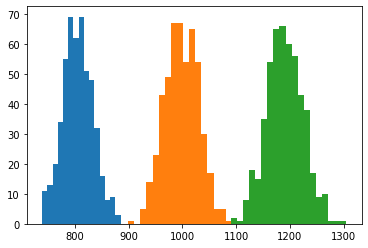

In [59]:
for s in [3000, 4000, 5000]:
    counts, bins = mutual_information.generate_histogram(s, size=500)
    plt.bar(x = (bins[1:] + bins[:-1])/2, height=counts, width=np.diff(bins))

In [58]:
bins

array([1074.        , 1080.37837838, 1086.75675676, 1093.13513514,
       1099.51351351, 1105.89189189, 1112.27027027, 1118.64864865,
       1125.02702703, 1131.40540541, 1137.78378378, 1144.16216216,
       1150.54054054, 1156.91891892, 1163.2972973 , 1169.67567568,
       1176.05405405, 1182.43243243, 1188.81081081, 1195.18918919,
       1201.56756757, 1207.94594595, 1214.32432432, 1220.7027027 ,
       1227.08108108, 1233.45945946, 1239.83783784, 1246.21621622,
       1252.59459459, 1258.97297297, 1265.35135135, 1271.72972973,
       1278.10810811, 1284.48648649, 1290.86486486, 1297.24324324,
       1303.62162162, 1310.        ])